# Deep Image Prior CTscan imaging of FASTMRI brain dataset

### Author: M. Ravasi

Welcome to the "Deep Learning in Scientific Inverse Problems" course!

The aim of this fifth notebook is to applying Deep Image Prior to CTscan imaging. We will be using a single brain image from the training dataset (which we will always keep in the testing dataset to provide a fair comparison of different methods). 

The problem that we wish to solve can be expressed as:

$$
\underset{\theta} {\mathrm{argmin}} \; \Vert \mathbf{d}- \mathbf{G}f_\theta(\mathbf{z}) \Vert_2^2
$$

where $f_\theta$ is an untrained network and $\mathbf{z}$ is an random noise realization.



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astra
import numpy as np
import matplotlib.pyplot as plt
import pylops
import torch
import torch.nn as nn

from scipy.sparse.linalg import lsqr
from tqdm.notebook import tqdm, trange
from pylops import TorchOperator
from pylops.utils.dottest import dottest
from pylops.utils.metrics import snr
from pyproximal.proximal import *
from pyproximal.optimization.primal import *

from ct import CT2D
from unet2d import ResUNet
from plotting import plt_comparison

device = 'cpu'

## Load brain image and create CT data

In [2]:
# Load data
brains = np.load('../data/brains_trainingdata.npy')
brain = brains[10]
nx, ny = brain.shape

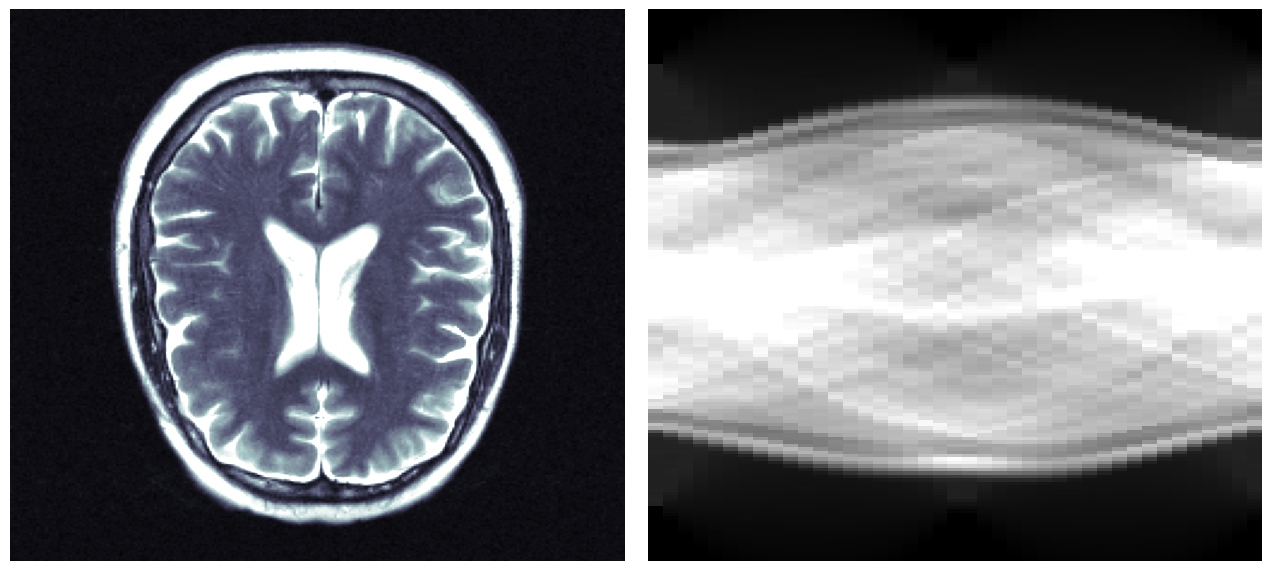

In [3]:
# Create data
nangles = 41
distdetectors = 2
ndetectors = 160

vol_geom = astra.create_vol_geom(nx, ny)
proj_geom = astra.create_proj_geom('parallel', distdetectors, ndetectors, 
                                   np.linspace(0, np.pi, nangles, False))

proj_id = astra.create_projector('strip', proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino(brain, proj_id)

fig, axs = plt.subplots(1, 2, figsize=(13, 6))
axs[0].imshow(brain, vmin=0, vmax=.5, cmap='bone')
axs[0].axis('tight')
axs[0].axis('off')
axs[1].imshow(sinogram.T, cmap='gray', vmin=0, vmax=6e1)
axs[1].axis('tight')
axs[1].axis('off')
plt.tight_layout()

In [4]:
# Create operator
Cop = CT2D((nx, ny), distdetectors, ndetectors, np.linspace(0, np.pi, nangles, False))
dottest(Cop, atol=1e-3, verb=True)

Dot test passed, v^H(Opu)=-1178.3341290113494 - u^H(Op^Hv)=-1178.3345157445187


True

## Deep image prior

In [5]:
n_epochs = 500 # number of epochs
lr = 1e-3 # learning rate

network = ResUNet(1, 1, hidden_channels=32, levels=2, subsampling=[[2,  2], [2, 2]]).to(device)
network = network.apply(network.weights_init) 
#summary(network, input_size=(1, nx, ny))

Loss:   0%|          | 0/500 [00:00<?, ?it/s]

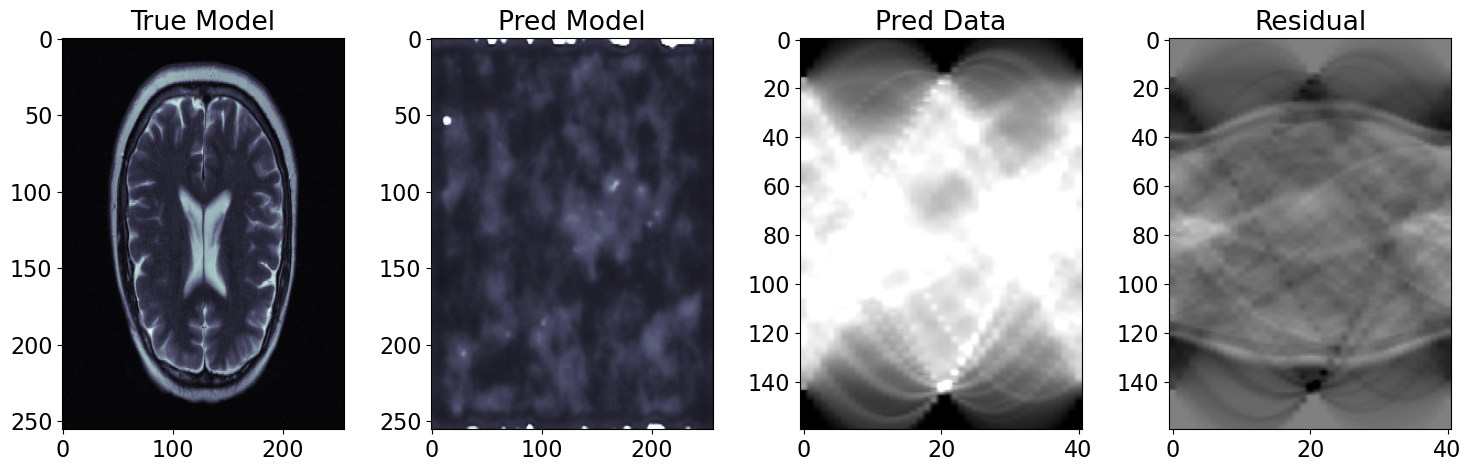

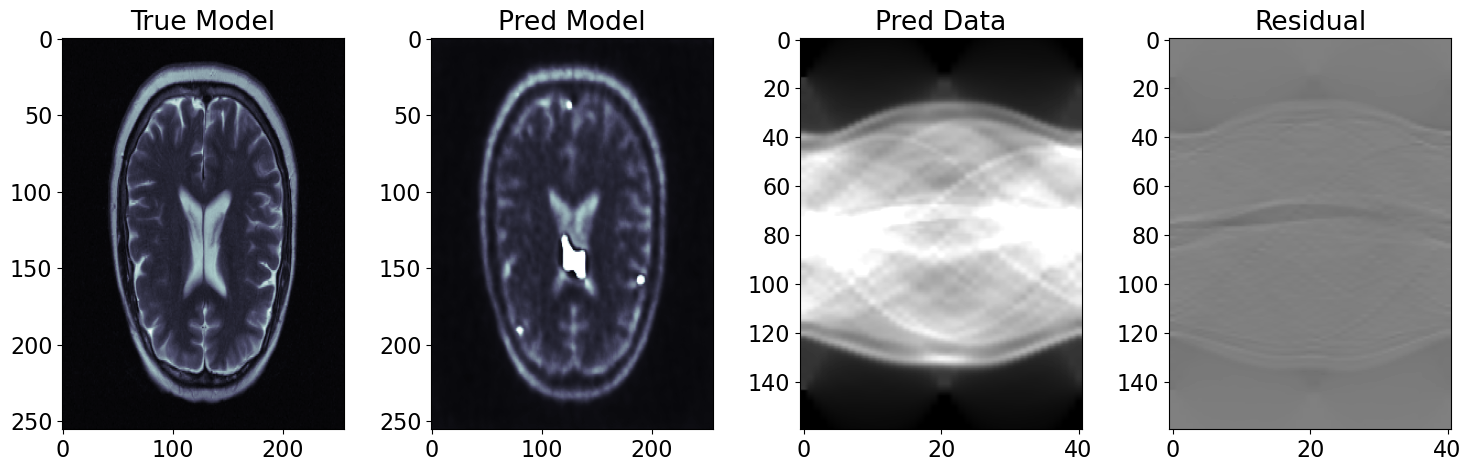

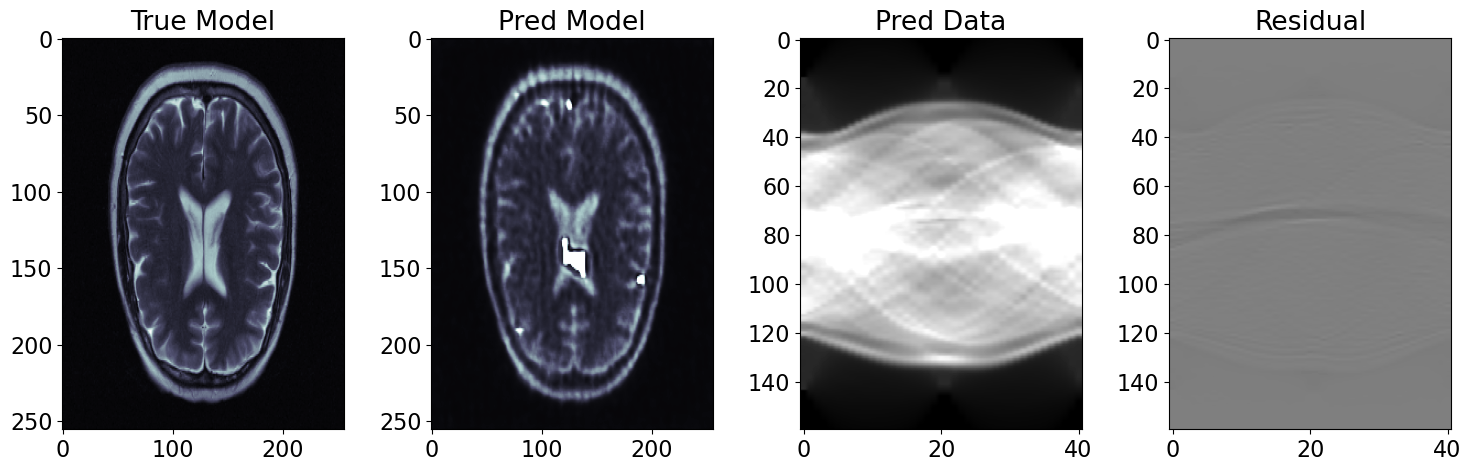

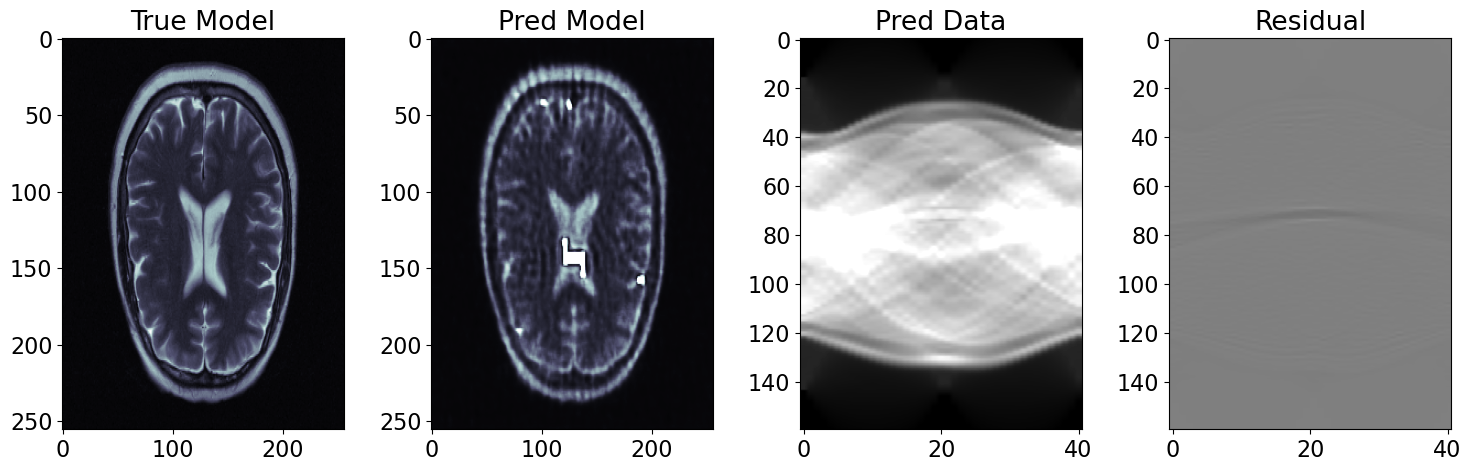

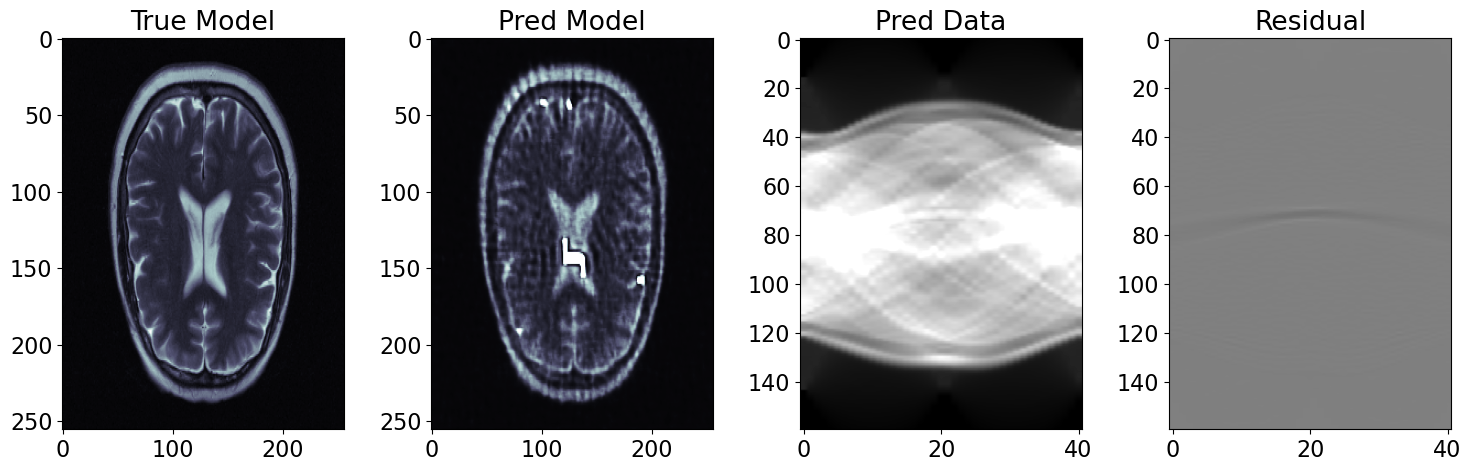

In [10]:
noise_torch = torch.randn(ny, nx).float().to(device)
sinogram_torch = torch.from_numpy(sinogram.ravel()).float().to(device)
Cop_torch = TorchOperator(Cop, device=device)

optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    
loss_history = []
err_history = []
network.train()

t = trange(n_epochs, desc='Loss', leave=True)
for epoch in t:
    optimizer.zero_grad()
    
    # predict data
    brainpred = network(noise_torch.unsqueeze(0).unsqueeze(0)).squeeze()
    brainpred = torch.sigmoid(brainpred)
    sinopred = Cop_torch.apply(brainpred.view(-1))
    
    # compute loss
    ls = torch.mean((sinogram_torch - sinopred)**2)
    
    # optimize
    ls.backward()
    optimizer.step()
    
    # track metrics
    loss_history.append(ls.item())
    err_history.append(np.linalg.norm(brainpred.cpu().detach().numpy() - brain))
    
    t.set_description('Loss=%g' % loss_history[-1])
    t.refresh() # to show immediately the update

    # visualize
    if epoch % 100 == 0:
        #print(f'Epoch: {epoch}, Loss: {loss_history[-1]}')
        
        vmin, vmax = 0, 1.
        fig, ax = plt.subplots(1,4, figsize=(15,5))
        ax0=ax[0].imshow(brain, cmap="bone" ,vmin=vmin, vmax=vmax)
        ax[0].set_title('True Model')
        ax[0].axis('tight')
        ax1=ax[1].imshow(brainpred.cpu().detach().numpy().reshape(brain.shape), 
                         cmap="bone" ,vmin=vmin, vmax=vmax)
        ax[1].set_title('Pred Model')
        ax[1].axis('tight')
        ax2=ax[2].imshow(sinopred.cpu().detach().numpy().reshape(sinogram.shape).T, 
                         cmap="gray", vmin=0, vmax=6e1)
        ax[2].set_title('Pred Data')
        ax[2].axis('tight')
        ax2=ax[3].imshow(sinogram.T - sinopred.cpu().detach().numpy().reshape(sinogram.shape).T, 
                         cmap="gray", vmin=-6e1, vmax=6e1)
        ax[3].set_title('Residual')
        ax[3].axis('tight')
        fig.tight_layout()

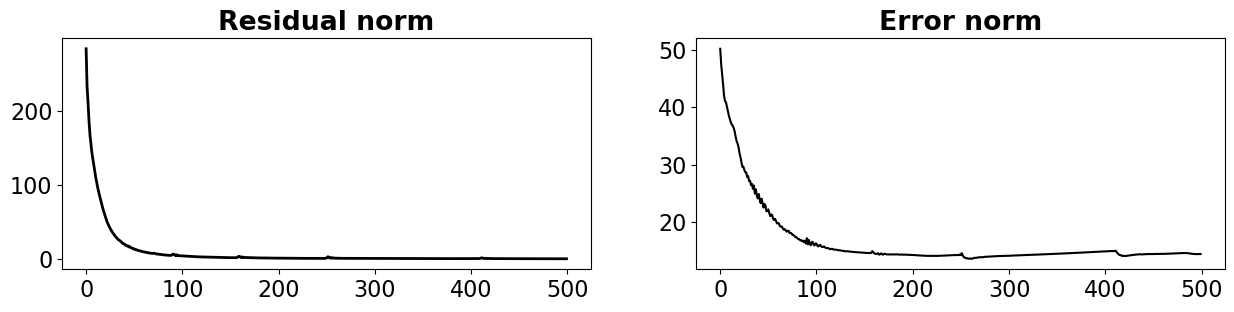

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].plot(loss_history, 'k', lw=2)
axs[0].set_title('Residual norm', fontweight='bold')
axs[1].plot(err_history, 'k')
axs[1].set_title('Error norm', fontweight='bold');

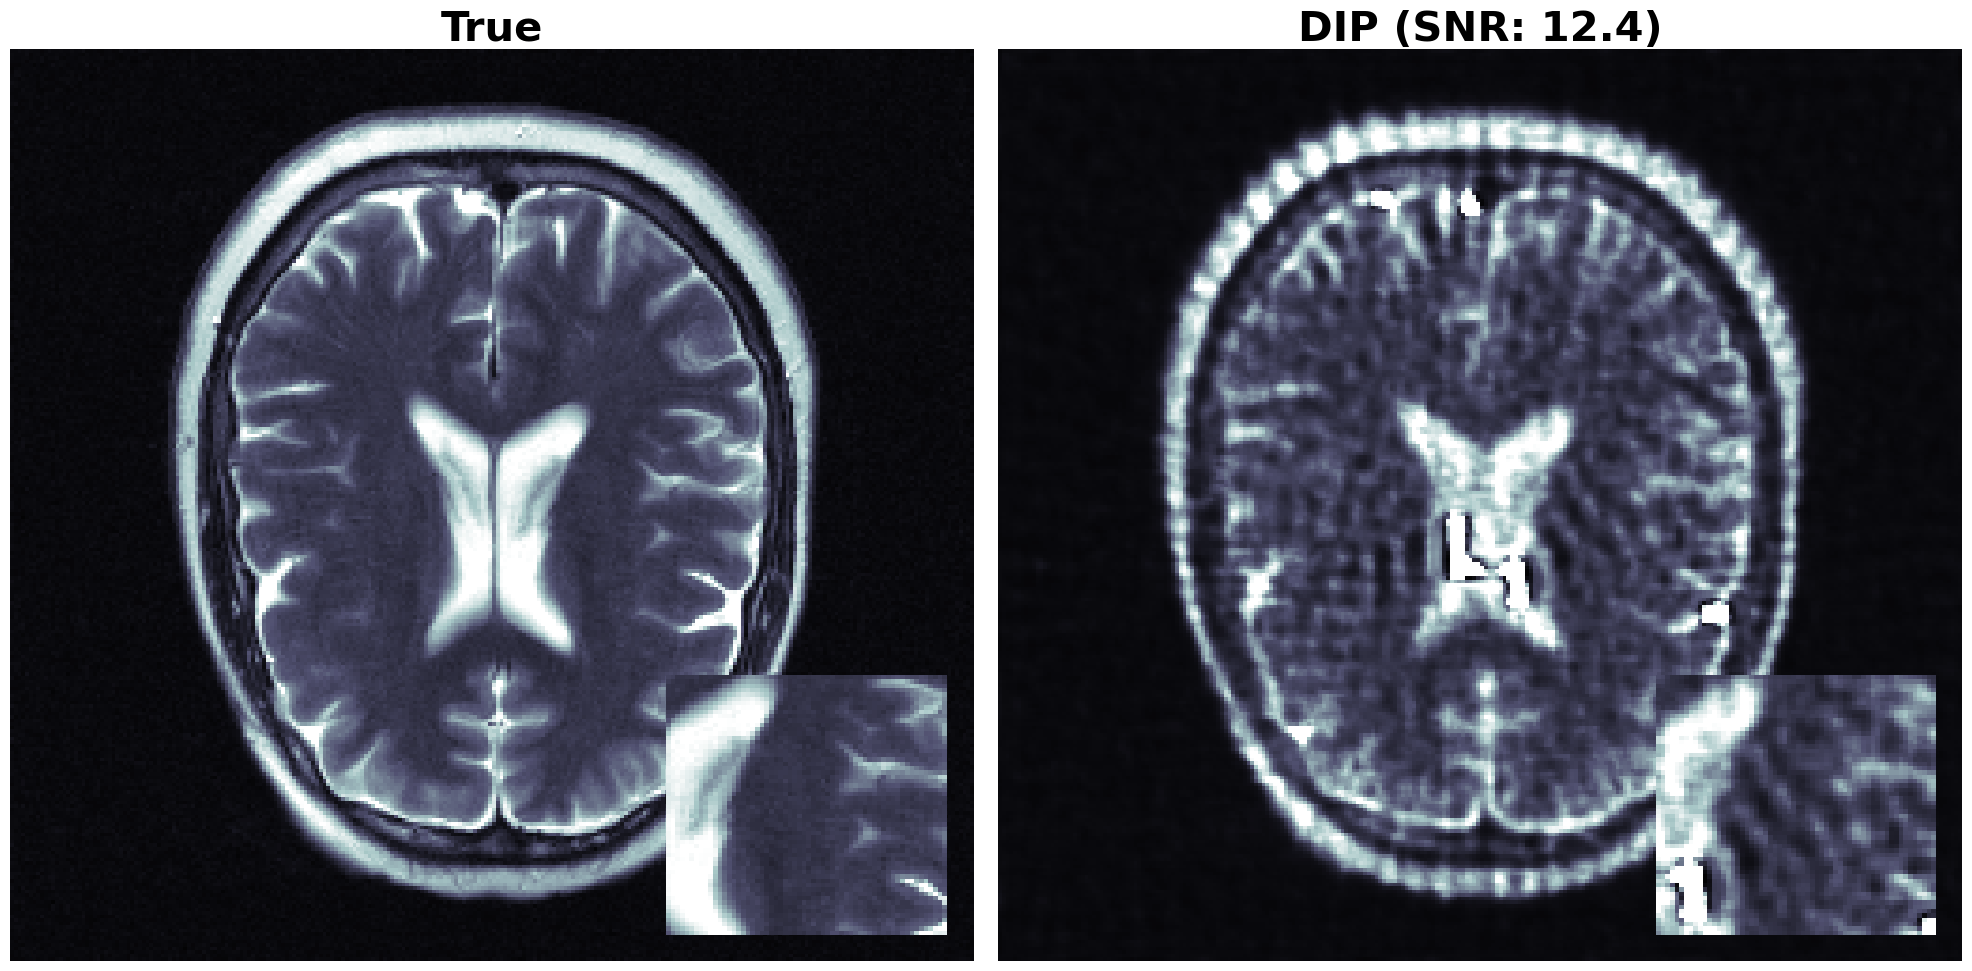

In [18]:
plt_comparison(brain, brainpred.cpu().detach().numpy(), cmap='bone', clim=(0, 0.7), 
               titles=['True', 'DIP'], zoom=(100, 160, 130, 190),
               metricname='SNR', metric=snr)